# Creating a Price Prediction Model using Airbnb Data of New York

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
%matplotlib inline

# 1. Understanding Data

#### Gather data

The detailed datasets listings.csv and reviews.csv of Airbnb listings for New York was obtained from http://insideairbnb.com/get-the-data.html

In [2]:
listings = pd.read_csv("listings.csv")
reviews = pd.read_csv("reviews.csv")

C:\Users\roshn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Assess & preliminary cleaning of data

In [3]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48864 entries, 0 to 48863
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(63)
memory usage: 39.5+ MB


#### Exploring columns in datasets

In [4]:
listings.iloc[0]

id                                                                           2595
listing_url                                     https://www.airbnb.com/rooms/2595
scrape_id                                                          20190806030549
last_scraped                                                           2019-08-07
name                                                        Skylit Midtown Castle
                                                              ...                
calculated_host_listings_count                                                  2
calculated_host_listings_count_entire_homes                                     1
calculated_host_listings_count_private_rooms                                    0
calculated_host_listings_count_shared_rooms                                     1
reviews_per_month                                                            0.39
Name: 0, Length: 106, dtype: object

#### Checking the number of rows and columns

In [5]:
print(listings.shape)
print(reviews.shape)

(48864, 106)
(1143036, 6)


#### For the listing dataset, it looks as though there are a number of columns containing missing values.

In [6]:
#check distribution of null values
pd.set_option('display.max_rows', 106)
listings.isnull().sum() != 0

id                                              False
listing_url                                     False
scrape_id                                       False
last_scraped                                    False
name                                             True
summary                                          True
space                                            True
description                                      True
experiences_offered                             False
neighborhood_overview                            True
notes                                            True
transit                                          True
access                                           True
interaction                                      True
house_rules                                      True
thumbnail_url                                    True
medium_url                                       True
picture_url                                     False
xl_picture_url              

In [7]:
#number of columns containing missing values
((listings.isnull().sum()) != 0).sum()

54

#### For the reviews dataset, there are only two columns containing missing values.

In [8]:
(reviews.isnull().sum()) != 0

listing_id       False
id               False
date             False
reviewer_id      False
reviewer_name     True
comments          True
dtype: bool

## 2. Cleaning the data

#### Dropping columns that only contain one unique value as they don't provide any predictive power.

In [9]:
#find columns in dataset that only contain one unique value
oneunique = [col for col in listings.columns.values if listings[col].nunique() == 1]
oneunique

['scrape_id',
 'experiences_offered',
 'country_code',
 'country',
 'has_availability',
 'is_business_travel_ready']

In [10]:
#drop the columns with one unique value
listings = listings.drop(columns = oneunique)

#### Dropping columns that contain 'url' in the name are also irrelevant as they contain no characteristics that lead to prediction of price.

In [11]:
#find columns containing 'url' in the name
url_col = [col for col in listings.columns.values if 'url' in col]
url_col

['listing_url',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url']

In [12]:
listings = listings.drop(columns = url_col)

#### Dropping columns that contain 'scraped' in the name are also irrelevant as they contain no characteristics that lead to prediction of price

In [13]:
#find columns containing 'scraped' in the name
scraped_col=[col for col in listings.columns.values if 'scraped' in col]
scraped_col

['last_scraped', 'calendar_last_scraped']

In [14]:
listings = listings.drop(columns = scraped_col)

#### Dropping irrelevant columns relating the host which will not impact analysis 

In [15]:
drop_cols=['id','host_id','host_name','host_location','host_about','host_neighbourhood',
           'calculated_host_listings_count','calculated_host_listings_count_entire_homes',
           'calculated_host_listings_count_shared_rooms','calculated_host_listings_count_private_rooms']
listings = listings.drop(columns = drop_cols)

#### Dropping columns related to reviews since we have other columns related to review score that encapsulates these columns

In [16]:
drop_cols = ['review_scores_accuracy','review_scores_cleanliness',
             'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']
listings = listings.drop(columns = drop_cols)

#### Dropping categorical columns that don't help in price prediction

In [17]:
drop_cols = ['name','summary','space','description','neighborhood_overview',
             'notes','transit','access','interaction','house_rules','amenities']
listings = listings.drop(columns = drop_cols)

#### Dropping rows with NaN values in more than 1 column

In [18]:
#Count of the missing values in the columns
listings[['bedrooms','bathrooms','beds']].isnull().sum()

bedrooms     27
bathrooms    56
beds         42
dtype: int64

In [19]:
listings = listings.dropna(subset=['bedrooms','bathrooms','beds']) 

#### The neighbourhood_group_cleansed column envelopes all other neighbourhood columns and gives a clear idea of neighbourhood

In [20]:
neighbourhood_col=[col for col in listings.columns.values if 'neighbourhood' in col]
neighbourhood_col

['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']

In [21]:
drop_cols=['neighbourhood','neighbourhood_cleansed']
listings = listings.drop(columns = drop_cols)

#### The state column should be NY for all rows, but it has errornous inputs, so dropping it.

In [22]:
#checking the unique values in state column
listings.state.unique()

array(['NY', nan, 'Ny', 'ny', 'MP', 'CA', 'NJ', 'New York '], dtype=object)

In [23]:
listings = listings.drop(columns = 'state')

#### Dropping these columns since they don't impact analysis

In [24]:
drop_cols=['street','smart_location','zipcode',
           'is_location_exact','first_review','last_review','calendar_updated','market']
listings = listings.drop(columns = drop_cols)

#### After checking the similarity of nights columns below, we decided to use maximum_nights and minimum_nights instead of the others.

In [25]:
#find columns containing 'nights' in the name
nights_col=[col for col in listings.columns.values if 'nights' in col]
nights_col

['minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm']

In [26]:
#Checking similarity between columns
print((listings['minimum_minimum_nights'] == listings['minimum_nights']).sum() / len(listings))
print((listings['maximum_minimum_nights'] == listings['minimum_nights']).sum() / len(listings))
print((listings['minimum_maximum_nights'] == listings['maximum_nights']).sum() / len(listings))
print((listings['minimum_nights_avg_ntm'] == listings['minimum_nights']).sum() / len(listings))
print((listings['maximum_nights_avg_ntm'] == listings['maximum_nights']).sum() / len(listings))

0.9588178592670071
0.9428208125679362
0.9881662872495334
0.9264751122869624
0.98833035952337


In [27]:
drop_cols = ['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
             'minimum_nights_avg_ntm','maximum_nights_avg_ntm']
listings = listings.drop(columns = drop_cols)

#### The availability_365 column envolopes all other shorter dated categorical bins and hence it was chosen and the other columns were dropped.

In [28]:
#find columns containing 'availibility' in the name
avail_col=[col for col in listings.columns.values if 'availability' in col]
avail_col

['availability_30', 'availability_60', 'availability_90', 'availability_365']

In [29]:
drop_cols = ['availability_30', 'availability_60', 'availability_90']
listings = listings.drop(columns = drop_cols)

#### Dropping columns with many row values as NA

In [30]:
#Count of number of NA values in rows
print((listings['license'].isnull().sum()))
print((listings['host_acceptance_rate'].isnull().sum()))
print((listings['jurisdiction_names'].isnull().sum()))
print((listings['weekly_price'].isnull().sum()))
print((listings['monthly_price'].isnull().sum()))
print((listings['cleaning_fee'].isnull().sum()))
print((listings['security_deposit'].isnull().sum()))
print((listings['square_feet'].isnull().sum()))

48737
48759
48748
42886
43639
10544
17228
48373


In [31]:
listings = listings.drop(columns = ['license','host_acceptance_rate','jurisdiction_names',
                        'weekly_price','monthly_price','cleaning_fee','security_deposit','square_feet'])

#### Dropping host_total_listings_count since host_total_listings_count and host_listings_count are same.

In [32]:
print((listings['host_total_listings_count'] == listings['host_listings_count']).sum() / len(listings))
listings = listings.drop(columns = ['host_total_listings_count'])

0.9996308373838676


## 3. Transforming strings into numerical values

#### Strip column of percentages

In [33]:
cols=['host_response_rate']
listings[cols] = listings[cols].replace('%', '', regex=True).astype(float)

#### Stripping columns of $ sign

In [34]:
listings['price']=listings['price'].replace('[\$,]', '', regex=True).astype(float)
listings['extra_people']=listings['extra_people'].replace('[\$,]', '', regex=True).astype(float)

## 4. Data Manipulation

#### Filling NaN values in a column with 0 value

In [35]:
listings['number_of_reviews_ltm'] = listings['number_of_reviews_ltm'].fillna(value=0)
listings['number_of_reviews'] = listings['number_of_reviews'].fillna(value=0)

#### Updating t and f values of columns to numerical values of 1 and 0

In [36]:
f = lambda x: 1 if x=='t' else 0
listings['instant_bookable'] = listings['instant_bookable'].apply(f)
listings['host_is_superhost'] = listings['host_is_superhost'].apply(f)
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].apply(f)
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].apply(f)
listings['require_guest_profile_picture'] = listings['require_guest_profile_picture'].apply(f)
listings['require_guest_phone_verification'] = listings['require_guest_phone_verification'].apply(f)
listings['host_identity_verified'] = listings['host_identity_verified'].apply(f)
listings['requires_license'] = listings['requires_license'].apply(f)

#### Updating NaN values to mean, median and mode of the column for further analysis

In [37]:
listings['host_response_rate'] = listings['host_response_rate'].fillna(listings['host_response_rate'].mean())
listings['review_scores_rating'] = listings['review_scores_rating'].fillna(listings['review_scores_rating'].mean())
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(listings['reviews_per_month'].mean())
listings['host_listings_count'] = listings['host_listings_count'].fillna(listings['host_listings_count'].median())
listings['host_identity_verified'] = listings['host_identity_verified'].fillna(listings['host_identity_verified'].median())
listings['host_response_time'] = listings['host_response_time'].fillna(listings['host_response_time'].mode()[0])
listings['cancellation_policy'] = listings['cancellation_policy'].fillna(listings['cancellation_policy'].mode()[0])
listings['city'] = listings['city'].fillna(listings['city'].mode()[0])

#### Updating host_since column from date to year and replace NaN to median value

In [38]:
listings['host_since'] = pd.DatetimeIndex(listings['host_since']).year
listings['host_since'] = listings['host_since'].fillna(listings['host_since'].median())

#### Calculating the number of  host verifications and storing it back

In [39]:
listings['host_verifications'] = listings['host_verifications'].apply(lambda x: len(x))

### Final Dataset: 

In [40]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48759 entries, 0 to 48863
Data columns (total 34 columns):
host_since                          48759 non-null float64
host_response_time                  48759 non-null object
host_response_rate                  48759 non-null float64
host_is_superhost                   48759 non-null int64
host_listings_count                 48759 non-null float64
host_verifications                  48759 non-null int64
host_has_profile_pic                48759 non-null int64
host_identity_verified              48759 non-null int64
neighbourhood_group_cleansed        48759 non-null object
city                                48759 non-null object
latitude                            48759 non-null float64
longitude                           48759 non-null float64
property_type                       48759 non-null object
room_type                           48759 non-null object
accommodates                        48759 non-null int64
bathrooms            

## 5. Data Visualization:

### Price Distribution

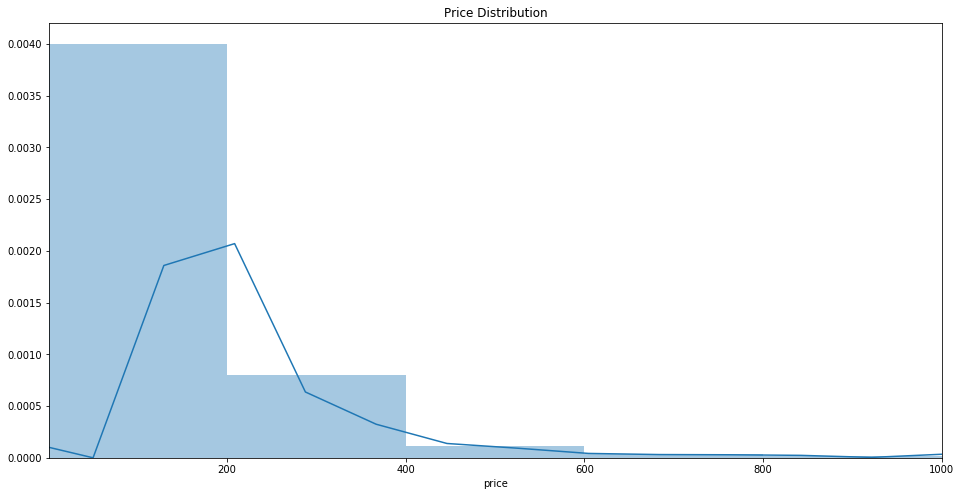

In [41]:
plt.figure(figsize=(16,8))
sns.distplot(listings['price'])
plt.xlim((1,1000))
plt.title('Price Distribution')
plt.show()

## Inspecting how the features affect the price:

### Property Type v/s Price

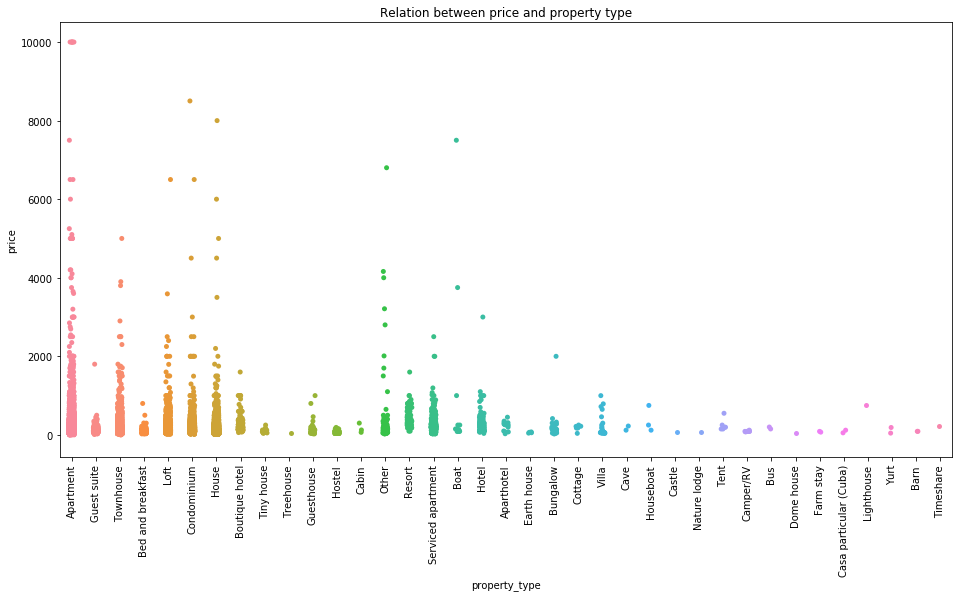

In [42]:
plt.figure(figsize=(16,8))
sns.stripplot(y =listings['price'],x=listings['property_type'])
plt.xticks(rotation = 90)
plt.title('Relation between price and property type')
plt.show()

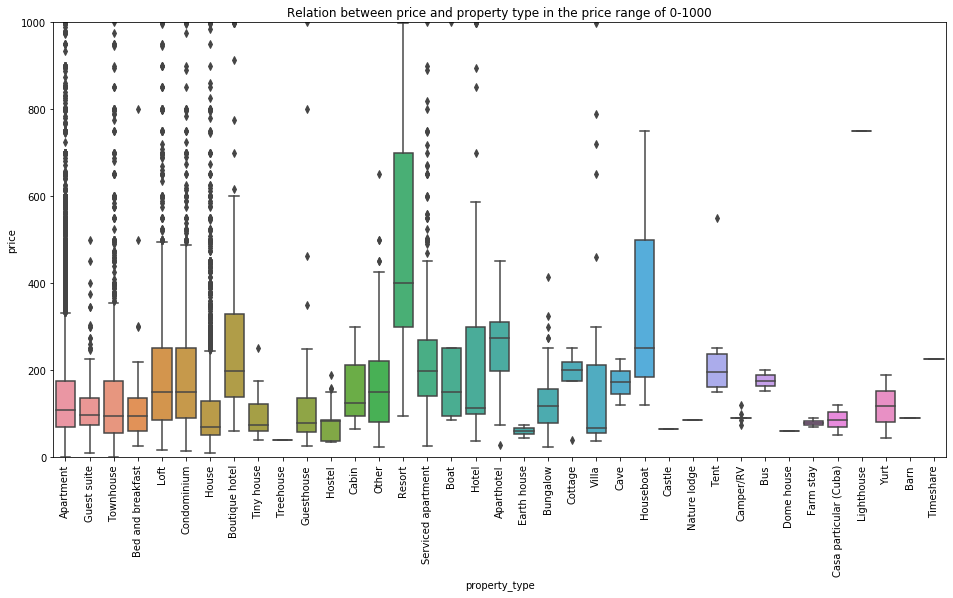

In [43]:
plt.figure(figsize=(16,8))
sns.boxplot(y =listings['price'],x=listings['property_type'])
plt.ylim((0,1000))
plt.xticks(rotation = 90)
plt.title('Relation between price and property type in the price range of 0-1000')
plt.show()

### Room Type v/s Price

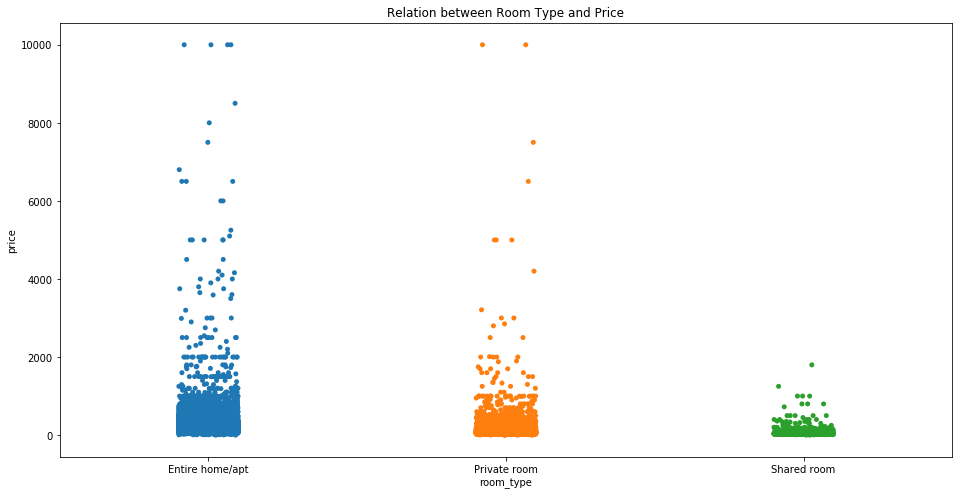

In [44]:
plt.figure(figsize=(16,8))
sns.stripplot(listings['room_type'],listings['price'])
plt.title('Relation between Room Type and Price')
plt.show()

### Plotting the Neighbourhood groups with Latitude and Longitudes

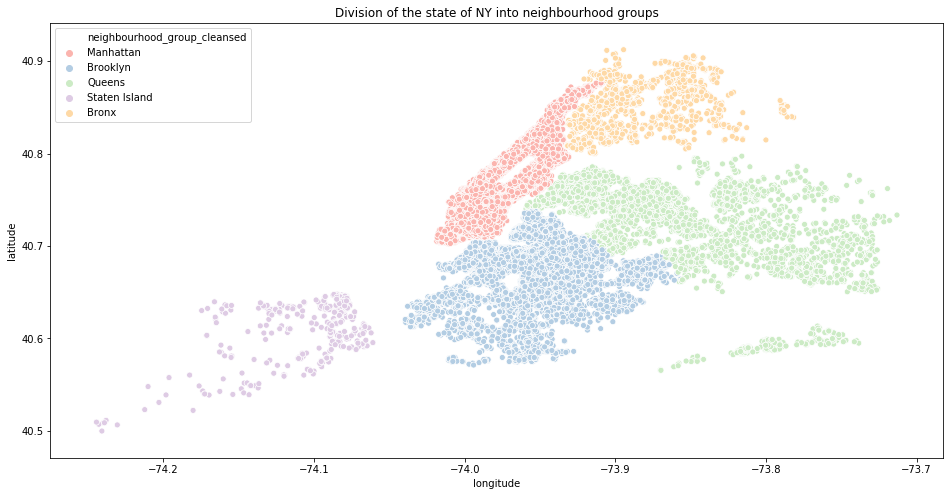

In [45]:
plt.figure(figsize=(16,8))
sns.scatterplot(y=listings.latitude,x=listings.longitude,hue=listings.neighbourhood_group_cleansed,palette="Pastel1")
plt.title('Division of the state of NY into neighbourhood groups')
plt.show()

### Plot of price in the state with Longitude and Latitudes

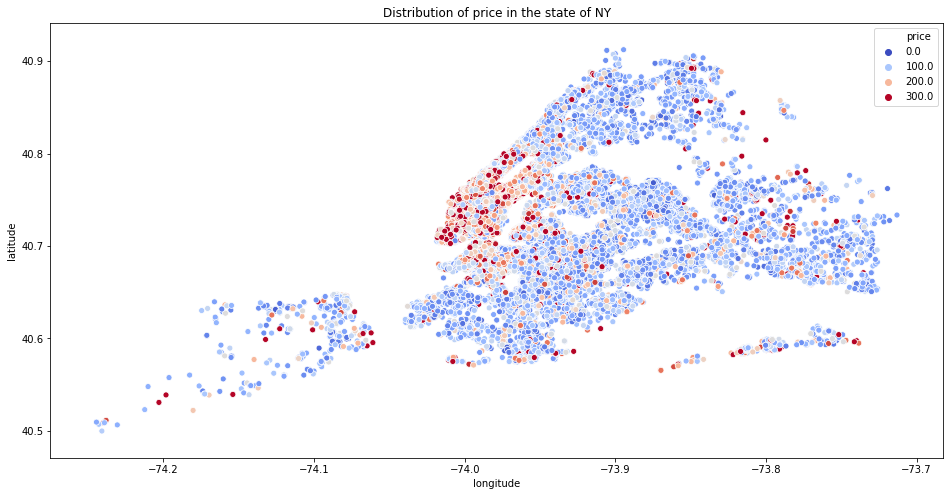

In [46]:
plt.figure(figsize=(16,8))
sns.scatterplot(y=listings.latitude,x=listings.longitude,hue=listings.price,palette="coolwarm",hue_norm  =(0,300))
plt.title('Distribution of price in the state of NY')
plt.show()

### Accomodates v/s Price

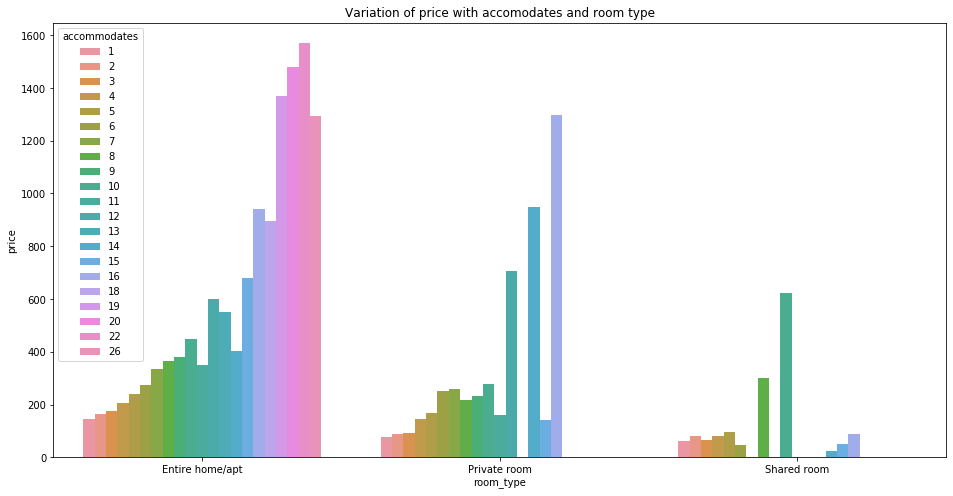

In [47]:
plt.figure(figsize=(16,8))
sns.barplot(x=listings['room_type'], y=listings['price'],hue=listings['accommodates'],ci=None)
plt.title('Variation of price with accomodates and room type')
plt.show()

### Distribution of single variables and relationships between two variables.

<Figure size 1440x576 with 0 Axes>

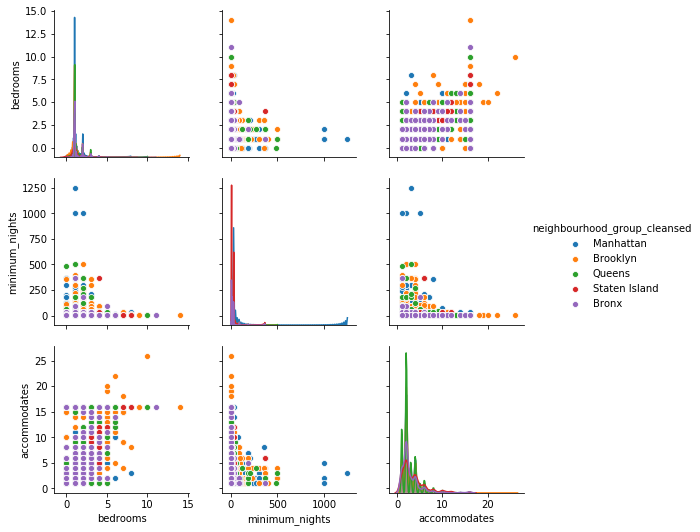

In [48]:
plt.figure(figsize=(20,8))
sns.pairplot(listings, vars = ['bedrooms','minimum_nights','accommodates'],hue='neighbourhood_group_cleansed')
plt.show()

### Rating v/s Price

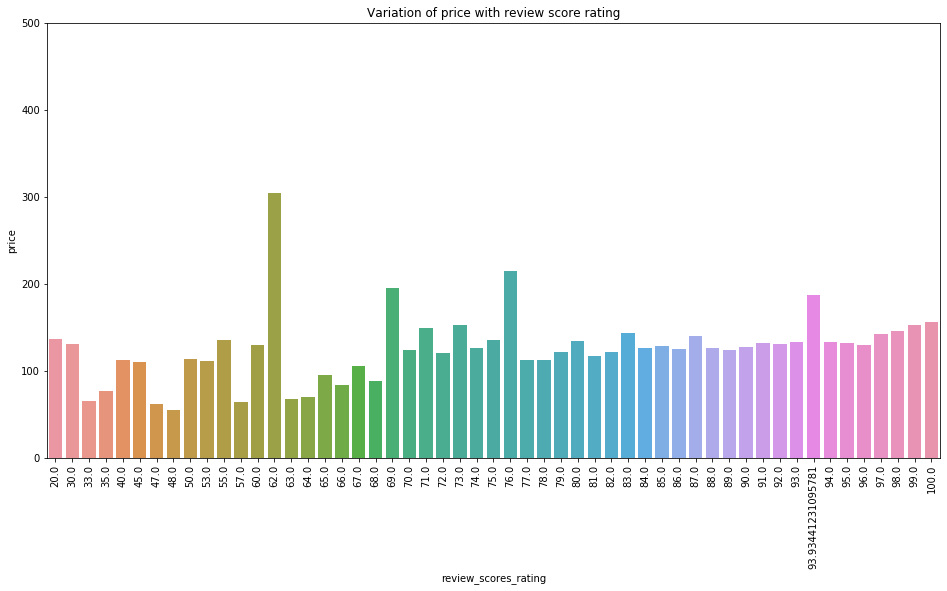

In [49]:
plt.figure(figsize=(16,8))
sns.barplot(y =listings['price'],x=listings['review_scores_rating'],ci = None)
plt.ylim((0,500))
plt.xticks(rotation = 90)
plt.title('Variation of price with review score rating')
plt.show()

### Price range of Listings

Text(0.5, 1.0, 'Histogram of listing prices')

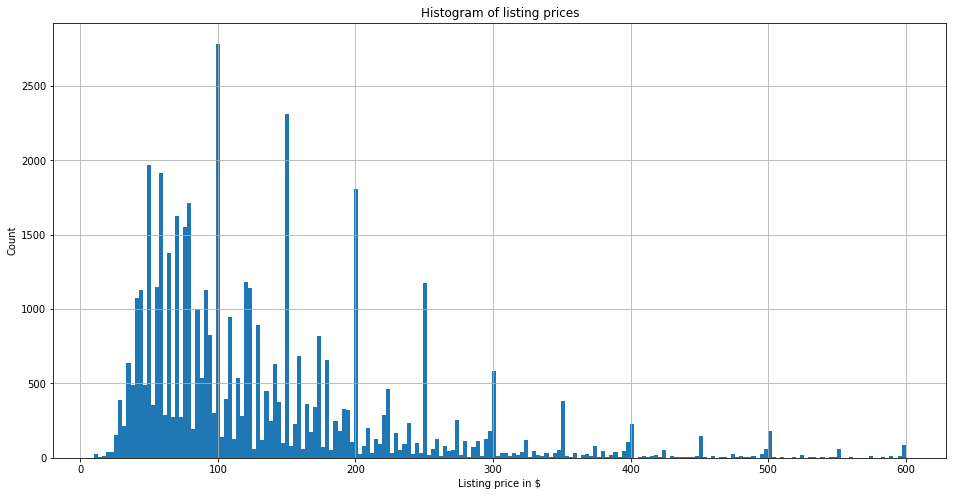

In [50]:
plt.figure(figsize=(16,8))
listings.loc[(listings.price <= 600) & (listings.price > 0)].price.hist(bins=200)
plt.ylabel('Count')
plt.xlabel('Listing price in $')
plt.title('Histogram of listing prices')

## 6. Finding the sentiment of Reviews:

#### Dropping the missing values in the rows

In [51]:
#number of missing values
print(reviews['comments'].isnull().sum())
reviews = reviews.dropna(subset =['comments'])

570



#### Eliminating the special characters in comments column:

In [52]:
reviews['comments'] = reviews['comments'].apply(lambda x: re.sub('[^A-Za-z0-9 ]','',str(x)))

#### Finding the polarity:

In [53]:
from textblob import TextBlob
reviews['polarity']=reviews['comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

#### Classifying the polarity:

In [54]:
reviews['res'] = reviews['polarity'].apply(lambda x:'positive' if x > 0.3 else 'negative' if x < -0.1 else 'neutral' )

In [55]:
reviews['res'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

#### Visualizing the nature of comments:

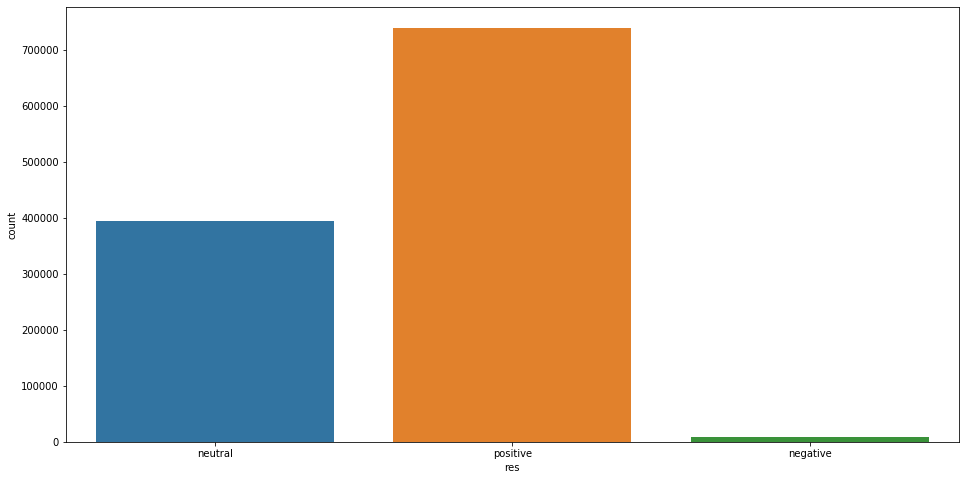

In [56]:
plt.figure(figsize=(16,8))
sns.countplot(x= 'res', data = reviews)

## 7. Price Prediction Model:

#### Creating a new dataframe with all the numerical columns:

In [57]:
listings_new = listings[['host_since','host_response_rate','host_listings_count','host_has_profile_pic',
             'host_identity_verified','latitude','longitude','accommodates','bathrooms',
             'bedrooms','beds','price','guests_included','extra_people',
             'minimum_nights','maximum_nights','availability_365','number_of_reviews',
             'number_of_reviews_ltm','review_scores_rating','requires_license','instant_bookable',
             'require_guest_profile_picture','require_guest_phone_verification','reviews_per_month','host_verifications']]

#### Converting the categorical columns to dummy values:

In [58]:
for categorical in ['city','property_type','room_type','neighbourhood_group_cleansed','cancellation_policy','bed_type','host_response_time']:
    listings_new = pd.concat([listings_new, pd.get_dummies(listings[categorical], drop_first = True)], axis=1)

#### Eliminating outliers using 2D Standard Deviation method:

In [59]:
std_2 = np.mean(listings_new['price']) + 2*np.std(listings_new['price'])
listings_new = listings_new.loc[listings_new['price'] > 0]
listings_new = listings_new.loc[listings_new['price'] < std_2]

### Implementing Linear Regression model:

RMSE test: 62.202
R^2 test: 0.558


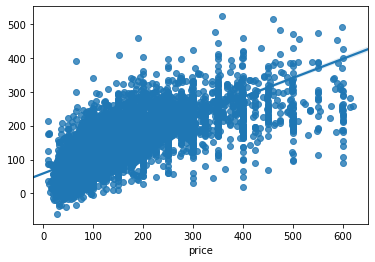

In [60]:
y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
rmse_lr = (mean_squared_error(y_test,pred))**(0.5)

print('RMSE test: %.3f' % rmse_lr)
print('R^2 test: %.3f' % (r2_score(y_test, pred)))

sns.regplot(y_test, pred)

### Implementing Ridge Regression model:

In [61]:
y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
model_r = Ridge(alpha = 2.0).fit(X_train, y_train)
model_r.fit(X_train, y_train)
pred = model_r.predict(X_test)
print('R^2 test: %.3f' % (r2_score(y_test, pred)))


R^2 test: 0.502


### Implementing Random Forest Regressor:

In [62]:
y = listings_new['price']
x = listings_new.drop('price', axis =1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)
rf = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print('R^2 test: %.3f' % (r2_score(y_test, pred)))

R^2 test: 0.676


### Conclusion:
Successfully created a price prediction model using Random Forest Regressor to predict the future prices of AirBnB whihc has a R2 score of 0.653.